In [1]:
# HIDDEN
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from pathlib import Path
from ds100_utils import fetch_and_cache
from datetime import datetime
from IPython.display import display

import yaml

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# Sam's special methods to display large DataFrames
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]

    row_arg = (0, len(df), nrows) if len(df) > nrows else fixed(0)
    col_arg = ((0, len(df.columns), ncols)
               if len(df.columns) > ncols else fixed(0))
    
    interact(peek, row=row_arg, col=col_arg)
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [3]:
def plot_vec(x_dir, y_dir):
    plt.quiver(0, 0, x_dir, y_dir, scale_units='xy', angles='xy',
               scale=0.1, color='red')

## PCA Intuition: Going from 2D to 1D

In [4]:
# Downloads from https://www.gapminder.org/data/
cm_path = 'child_mortality_0_5_year_olds_dying_per_1000_born.csv'
fe_path = 'children_per_woman_total_fertility.csv'
cm = pd.read_csv(cm_path).set_index('country')['2017'].to_frame()/10
fe = pd.read_csv(fe_path).set_index('country')['2017'].to_frame()
data = cm.merge(fe, left_index=True, right_index=True).dropna()
data.columns = ['mortality', 'fertility']
data.head()

,mortality,fertility
country,,
Afghanistan,6.82,4.48
Albania,1.33,1.71
Algeria,2.39,2.71
Angola,8.31,5.62
Antigua and Barbuda,0.82,2.04


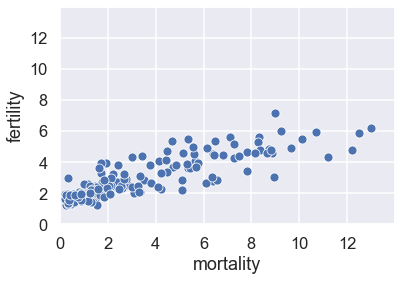

In [5]:
def scatter():
    sns.scatterplot('mortality', 'fertility', data=data)
    plt.xlim([0, 14])
    plt.ylim([0, 14])
    plt.xticks(np.arange(0, 14, 2))
    plt.yticks(np.arange(0, 14, 2))


scatter()

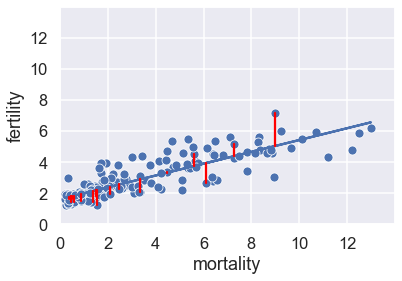

In [6]:
x, y = data['mortality'], data['fertility']
slope_x, intercept_x = np.polyfit(x, y, 1) # simple linear regression

scatter()
plt.plot(x, slope_x * x + intercept_x)
for _, row in data.sample(20).iterrows():
    x, y = row['mortality'], row['fertility']
    plt.plot([x, x], [slope_x * x + intercept_x, y], c='red')

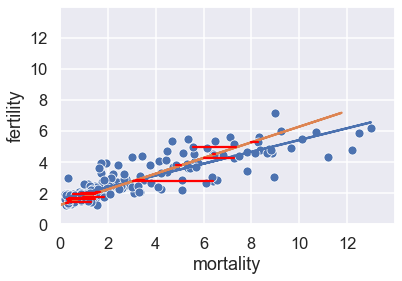

In [7]:
x, y = data['mortality'], data['fertility']
slope_y, intercept_y = np.polyfit(y, x, 1) # simple linear regression

scatter()
plt.plot(x, slope_x * x + intercept_x)
plt.plot(slope_y * y + intercept_y, y)
for _, row in data.sample(20).iterrows():
    x, y = row['mortality'], row['fertility']
    plt.plot([x, slope_y * y + intercept_y], [y, y], c='red')

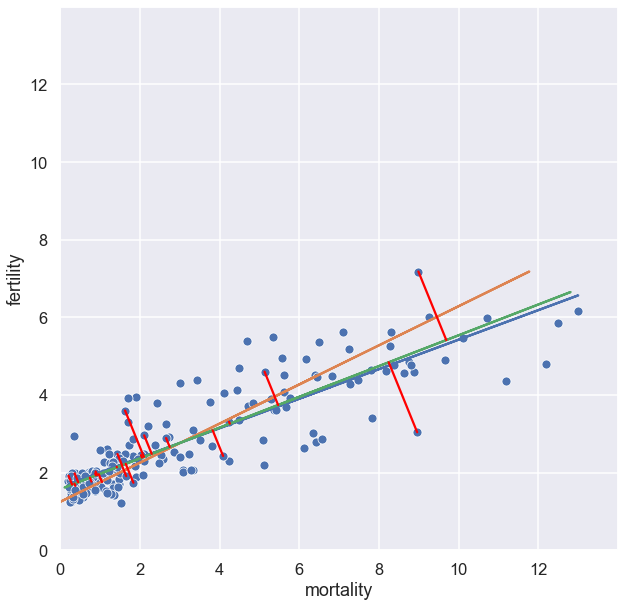

In [8]:
from sklearn.decomposition import PCA

plt.figure(figsize=(10, 10))

D = data.values
means = np.mean(D, axis=0)
first_pc = PCA(n_components=1).fit(D).components_[0]

# Find the projection of each point onto the 
#   first principal component (first_pc).
line = np.outer((D - means) @ first_pc, first_pc) + means

x, y = data['mortality'], data['fertility']
scatter()
plt.plot(x, slope_x * x + intercept_x) # regression line for x
plt.plot(slope_y * y + intercept_y, y) # regression line for y
plt.plot(line[:, 0], line[:, 1])       # principal component line

for i, row in data.reset_index().sample(20).iterrows():
    x, y = row['mortality'], row['fertility']
    xp, yp = line[i, :]
    plt.plot([x, xp], [y, yp], c='red')

## PCA on Legislator Votes

In [9]:
# From Lecture 4
base_url = 'https://github.com/unitedstates/congress-legislators/raw/master/'
legislators_path = 'legislators-current.yaml'
f = fetch_and_cache(base_url + legislators_path, legislators_path)
legislators_data = yaml.safe_load(open(f))

def to_date(s):
    return datetime.strptime(s, '%Y-%m-%d')

legs = pd.DataFrame(
    columns=['leg_id', 'first', 'last', 'gender', 'state', 'chamber', 'party', 'birthday'],
    data=[[x['id']['bioguide'], 
           x['name']['first'],
           x['name']['last'],
           x['bio']['gender'],
           x['terms'][-1]['state'],
           x['terms'][-1]['type'],
           x['terms'][-1]['party'],
           to_date(x['bio']['birthday'])] for x in legislators_data])

legs.head(3)

Using cached version that was downloaded (UTC): Mon Jul  8 22:33:30 2019


,leg_id,first,last,gender,state,chamber,party,birthday
0,B000944,Sherrod,Brown,M,OH,sen,Democrat,1952-11-09
1,C000127,Maria,Cantwell,F,WA,sen,Democrat,1958-10-13
2,C000141,Benjamin,Cardin,M,MD,sen,Democrat,1943-10-05


In [10]:
# February 2019 House of Representatives roll call votes
# Downloaded using https://github.com/eyeseast/propublica-congress
# See the lec09 house votes notebook for details.
votes = pd.read_csv('votes.csv')
votes.head()

,chamber,session,roll call,member,vote
0,House,1,87,A000374,No
1,House,1,87,A000370,Yes
2,House,1,87,A000055,No
3,House,1,87,A000371,Yes
4,House,1,87,A000372,No


In [11]:
votes.merge(legs, left_on='member', right_on='leg_id').sample(5)

,chamber_x,session,roll call,member,...,state,chamber_y,party,birthday
8639,House,1,72,T000484,...,NM,rep,Democrat,1984-11-15
4144,House,1,79,J000032,...,TX,rep,Democrat,1950-01-12
446,House,1,81,B001287,...,CA,rep,Democrat,1965-03-02
8049,House,1,68,S001199,...,PA,rep,Republican,1964-01-23
6747,House,1,72,P000597,...,ME,rep,Democrat,1955-04-02


In [12]:
yes_no = votes[votes['vote'] == 'Yes']
vote_pivot = yes_no.pivot_table(index='member', 
                                columns='roll call', 
                                values='vote', 
                                aggfunc=len, 
                                fill_value=0)
print(vote_pivot.shape)
vote_pivot.head()

(436, 22)


roll call,66,67,68,69,...,84,85,86,87
member,,,,,,,,,
A000055,1,1,0,0,...,1,0,0,0
A000367,0,0,0,0,...,1,0,0,0
A000369,1,1,0,0,...,1,0,0,1
A000370,1,1,1,1,...,1,1,1,1
A000371,1,1,1,1,...,1,1,1,1


## Select Attributes

In [13]:
np.var(vote_pivot, axis=0).sort_values()

roll call
82    0.03
84    0.04
70    0.04
      ... 
78    0.25
69    0.25
80    0.25
Length: 22, dtype: float64

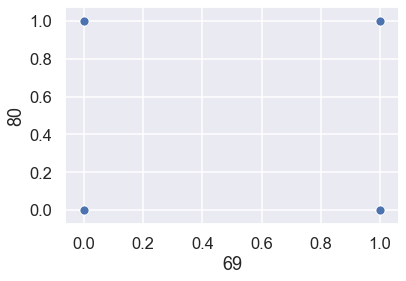

In [14]:
sns.scatterplot(69, 80, data=vote_pivot);

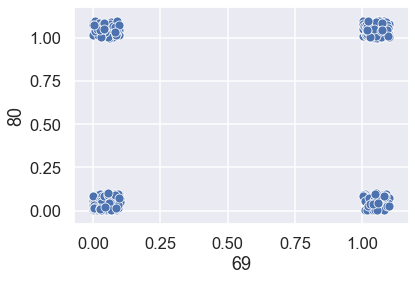

In [15]:
sns.scatterplot(69, 80, data=vote_pivot + np.random.random(vote_pivot.shape) * 0.1);

## PCA

In [16]:
D = vote_pivot.values
m = D.shape[0]
X = (D - np.mean(D, axis=0)) / np.sqrt(m)
u, s, vt = np.linalg.svd(X, full_matrices=False)

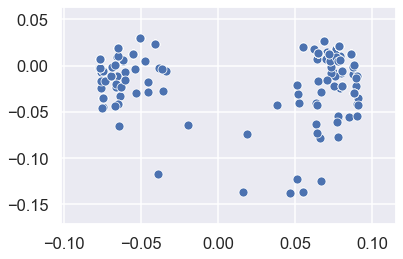

In [17]:
t = X @ vt.T
sns.scatterplot(x=t[:, 0], y=t[:, 1]);

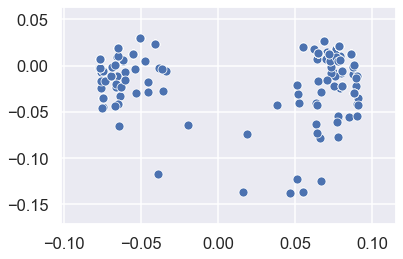

In [18]:
t = u * s
sns.scatterplot(x=t[:, 0], y=t[:, 1]);

In [19]:
vote2d = pd.DataFrame({
    'member': vote_pivot.index,
    'pc1': t[:, 0],
    'pc2': t[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

vote2d[vote2d['pc1'] < 0]['party'].value_counts()

Democrat    231
Name: party, dtype: int64

In [20]:
vote2d[vote2d['pc1'] > 0]['party'].value_counts()

Republican     197
Democrat         7
Independent      1
Name: party, dtype: int64

In [21]:
vote2d[vote2d['pc2'] < -0.1]

,member,pc1,pc2,leg_id,...,state,chamber,party,birthday
8,A000376,0.05,-0.12,A000376,...,TX,rep,Democrat,1983-04-15
107,D000624,0.02,-0.14,D000624,...,MI,rep,Democrat,1953-11-23
151,G000582,0.07,-0.12,G000582,...,PR,rep,Republican,1976-08-05
...,...,...,...,...,...,...,...,...,...
309,P000610,0.06,-0.14,P000610,...,VI,rep,Democrat,1966-05-13
358,S001177,0.06,-0.14,S001177,...,MP,rep,Democrat,1955-01-19
416,W000808,-0.04,-0.12,W000808,...,FL,rep,Democrat,1942-11-05


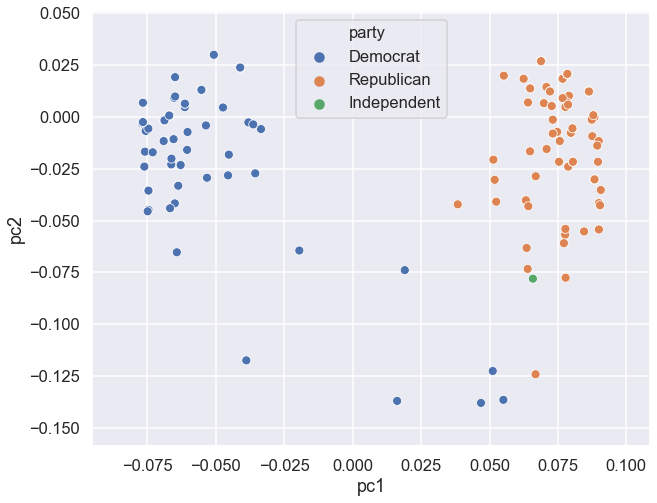

In [22]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pc1', y='pc2', hue='party',
                hue_order=['Democrat', 'Republican', 'Independent'],
                data=vote2d);

What's going on here?

In [23]:
display_df(vote_pivot.loc['P000197'], rows=22)

roll call
66    0
67    0
68    0
69    0
70    0
71    0
72    0
73    0
74    0
75    0
76    0
77    0
78    0
79    0
80    0
81    0
82    0
83    0
84    0
85    0
86    0
87    1
Name: P000197, dtype: int64

In [24]:
legs.query('leg_id == "P000197"')

,leg_id,first,last,gender,state,chamber,party,birthday
182,P000197,Nancy,Pelosi,F,CA,rep,Democrat,1940-03-26


In [25]:
df = votes[votes['member'].isin(vote2d[vote2d['pc2'] < -0.1]['member'])]
display_df(df.groupby(['member', 'vote']).size(), 17)

member   vote      
A000376  Not Voting    20
         Yes            2
D000624  Not Voting    19
         Yes            3
G000582  No             1
         Yes            2
N000147  No             2
         Yes            1
P000197  Speaker       21
         Yes            1
P000610  No             2
         Yes            1
S001177  No             2
         Yes            1
W000808  No             1
         Not Voting    13
         Yes            8
dtype: int64

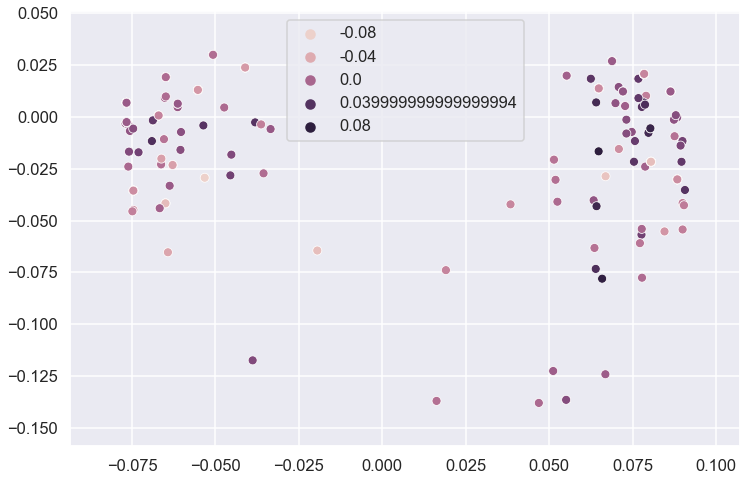

In [26]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=t[:, 0], y=t[:, 1], hue=t[:, 2]);

In [27]:
yes_no_count = yes_no.groupby('member').size()
regulars = vote_pivot[yes_no_count > 12]
regulars.head()

roll call,66,67,68,69,...,84,85,86,87
member,,,,,,,,,
A000055,1,1,0,0,...,1,0,0,0
A000369,1,1,0,0,...,1,0,0,1
A000370,1,1,1,1,...,1,1,1,1
A000371,1,1,1,1,...,1,1,1,1
A000375,1,1,0,0,...,1,0,0,0


In [28]:
regulars.merge(legs, left_index=True, right_on='leg_id')['party'].value_counts()

Democrat      229
Republican    139
Name: party, dtype: int64

In [29]:
D = regulars.values
m = D.shape[0]
X = (D - np.mean(D, axis=0)) / np.sqrt(m)
u, s, vt = np.linalg.svd(X, full_matrices=False)

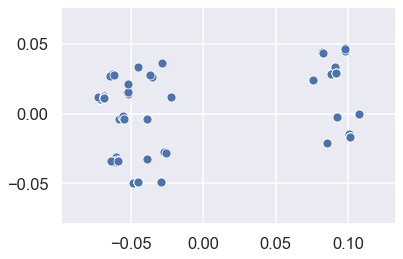

In [30]:
t = u * s
sns.scatterplot(x=t[:, 0], y=t[:, 1]);

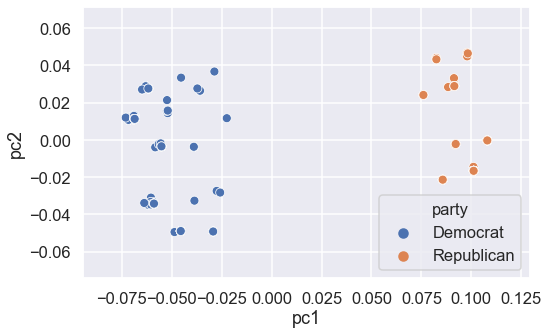

In [31]:
vote2d = pd.DataFrame({
    'member': regulars.index,
    'pc1': t[:, 0],
    'pc2': t[:, 1]
}).merge(legs, left_on='member', right_on='leg_id')

plt.figure(figsize=(8, 5))
sns.scatterplot('pc1', 'pc2', hue='party',
                hue_order=['Democrat', 'Republican'], data=vote2d)

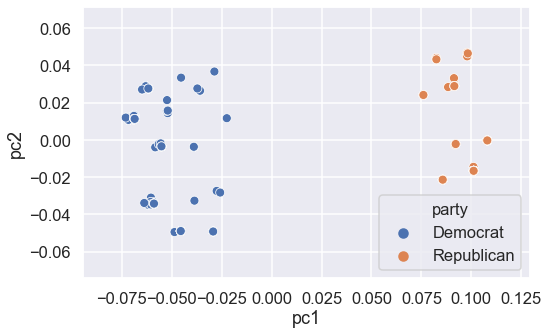

In [32]:
plt.figure(figsize=(8, 5))
sns.scatterplot('pc1', 'pc2', hue='party',
                hue_order=['Democrat', 'Republican'], data=vote2d)

In [33]:
display_df(vote2d.query('first == "Barbara"'), cols=11)
b_lee = 186

,member,pc1,pc2,leg_id,first,last,gender,state,chamber,party,birthday
186,L000551,-0.07,0.01,L000551,Barbara,Lee,F,CA,rep,Democrat,1946-07-16


Text(-0.075, 0.05, 'Barbara Lee')

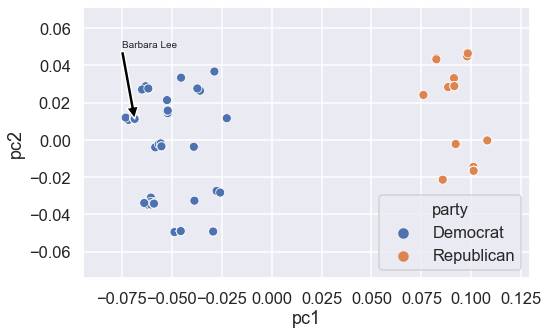

In [34]:
plt.figure(figsize=(8, 5))
sns.scatterplot('pc1', 'pc2', hue='party',
                hue_order=['Democrat', 'Republican'], data=vote2d)
plt.annotate('Barbara Lee',
             (vote2d.loc[b_lee, 'pc1'], vote2d.loc[b_lee, 'pc2']),
             xytext=(-0.075, 0.05),
             arrowprops=dict(facecolor='black'))

The first principal component seems to capture party affiliation. What about the second?

From https://www.govtrack.us/about/analysis#ideology:

> The statistical method behind this analysis is Principal Components Analysis, also known as dimensionality reduction. Principal Components Analysis is a statistical technique that reveals underlying patterns in data.

Using a somewhat different method, they conclude that the second principal component captures "ideology".

## Variance

In [35]:
np.round(s**2, 2)

array([2.26, 0.19, 0.15, ..., 0.  , 0.  , 0.  ])

In [36]:
sum(s ** 2)

3.069094104442346

In [37]:
np.var(D, axis=0)

array([0.02, 0.02, 0.24, ..., 0.24, 0.24, 0.18])

In [38]:
sum(np.var(D, axis=0))

3.0690941044423448

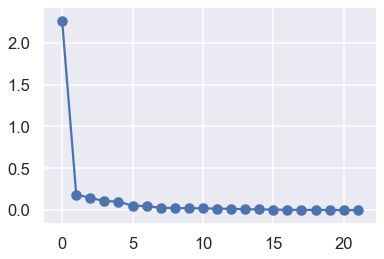

In [39]:
# scree plot
plt.plot(np.arange(len(s)), s**2);
plt.scatter(np.arange(len(s)), s**2);

In [40]:
np.round(s**2 / sum(s** 2), 2)

array([0.74, 0.06, 0.05, ..., 0.  , 0.  , 0.  ])

In [41]:
np.round(np.cumsum(s**2) / sum(s** 2), 2)

array([0.74, 0.8 , 0.85, ..., 1.  , 1.  , 1.  ])

In [42]:
# Variance from top two votes
sum(sorted(np.var(D, axis=0))[-2:]) / sum(np.var(D, axis=0))

0.16106431456900258

So PCA with 2 dimensions captures about 5 times as much variance as just picking two columns.

## Interpretation

In [43]:
vt[0, :]

array([ 0.  ,  0.  , -0.32, ..., -0.32, -0.32, -0.13])

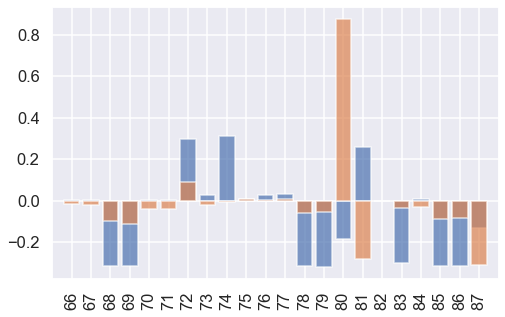

In [44]:
plt.figure(figsize=(8, 5))

num_votes = vt.shape[1]
votes = regulars.columns

def plot_pc(k):
    plt.bar(votes, vt[k, :], alpha=0.7)
    plt.xlim((min(votes)-1, max(votes)+1))
    plt.xticks(votes, rotation=90);

plot_pc(0)
plot_pc(1)

## Analyzing Votes

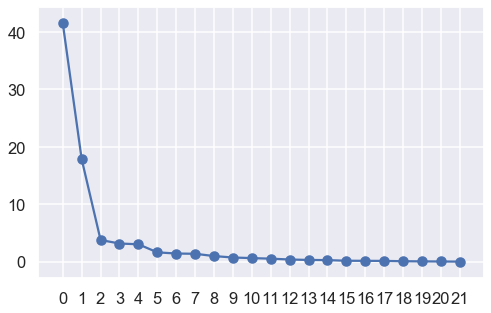

In [45]:
plt.figure(figsize=(8, 5))
D = vote_pivot.values.T
m = D.shape[0]
X = (D - np.mean(D, axis=0)) / np.sqrt(m)
u, s, vt = np.linalg.svd(X, full_matrices=False)
plt.plot(np.arange(len(s)), s**2);
plt.scatter(np.arange(len(s)), s**2);
plt.xticks(np.arange(len(s)));

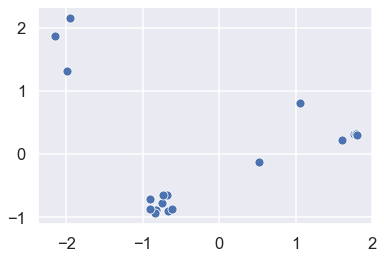

In [46]:
t = u * s
sns.scatterplot(x=t[:, 0], y=t[:, 1]);

In [47]:
sorted(zip(t[:, 0], votes))

[(-2.1468427450390704, 74),
 (-1.993171730427549, 81),
 (-1.9543713055743204, 72),
 (-0.9021553717697717, 73),
 (-0.9000148185499677, 84),
 (-0.8456804161643559, 70),
 (-0.8438552364026883, 82),
 (-0.8313051938435619, 71),
 (-0.7511666791511926, 75),
 (-0.7371949340309057, 77),
 (-0.6835723536173278, 76),
 (-0.6709746212467893, 66),
 (-0.6100716768825319, 67),
 (0.5228428369588903, 87),
 (1.0485858097667438, 80),
 (1.5989037929221537, 83),
 (1.7603789856354768, 69),
 (1.771123346677043, 68),
 (1.7870018616853771, 78),
 (1.7917136669407356, 79),
 (1.7921464285197972, 85),
 (1.7976803535938148, 86)]